# Machine Learning for Telecom with RandomForestClassifer

## Introduction

Machine Learning for Telecom with Randomforestclassifer is a supervised learning algorithm for classifying Call Detail Records in Telecom data. This notebook demonstrates exploration of data, feature Selection, auto feature importances selection and Evalution of CDR dataset to classify CallDisconnectReason with Spark ML RandomForestClassifier. 


In [1]:
%config IPCompleter.greedy=True

In [2]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

Using S3 Select, enables applications to retrieve only a subset of data from an object by using simple SQL expressions. By using S3 Select to retrieve only the data, you can achieve drastic performance increases – in many cases you can get as much as a 400% improvement.

In [3]:
cdr_start_loc = "<%CDRStartFile%>"
cdr_stop_loc = "<%CDRStopFile%>"
cdr_start_sample_loc = "<%CDRStartSampleFile%>"
cdr_stop_sample_loc = "<%CDRStopSampleFile%>"

df = spark.read.format("s3select").parquet(cdr_stop_sample_loc)

df.createOrReplaceTempView("cdr")

In [4]:
def build_schema():
    """Build and return a schema to use for the sample data."""
    schema = StructType(
            [
                StructField("Accounting_ID", StringType(), True),
                StructField("Start_Time_MM_DD_YYYY", StringType(), True),
                StructField("Start_Time_HH_MM_SS_s", StringType(), True),
                StructField("Call_Service_Duration", StringType(), True),
                StructField("Call_Disconnect_Reason", StringType(), True),
                StructField("Calling_Number", StringType(), True),
                StructField("Called_Number", StringType(), True)
            ]
        )
    return schema

# Exploratary Data Analysis

In [5]:
import matplotlib.pyplot as plt

stopDF = spark.sql("SELECT * from cdr where _c0 = 'STOP'")
newStopPd = stopDF.toPandas()
stopPd = newStopPd.dropna(axis=1)
print(stopPd.columns)

# Filter out Numeric Columns
stopNCdf = stopPd._get_numeric_data()
stopNCdf.columns 
print(stopNCdf.columns)

Index(['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9',
       '_c10', '_c11', '_c12', '_c13', '_c14', '_c15', '_c16', '_c17', '_c19',
       '_c20', '_c22', '_c24', '_c26', '_c27', '_c28', '_c29', '_c30', '_c31',
       '_c32', '_c33', '_c35', '_c37', '_c42', '_c45', '_c49', '_c50', '_c51',
       '_c52', '_c53', '_c54', '_c55', '_c58', '_c59', '_c60', '_c61', '_c63',
       '_c64', '_c65', '_c66', '_c67', '_c68', '_c69', '_c70', '_c73', '_c74',
       '_c77', '_c78', '_c79', '_c80', '_c81', '_c84', '_c90', '_c94', '_c101',
       '_c105', '_c106', '_c107', '_c108', '_c109', '_c110', '_c112', '_c113',
       '_c114', '_c115', '_c116', '_c117', '_c118', '_c119', '_c124', '_c125',
       '_c126', '_c127', '_c128', '_c137', '_c140', '_c143', '_c148', '_c149',
       '_c150', '_c159', '_c160', '_c181', '_c182'],
      dtype='object')
Index([], dtype='object')


# Feature Selection

In [6]:
dataDF = spark.sql("SELECT _c2,_c5,_c6,_c13,_c14,_c19,_c20 from cdr where _c0 = 'STOP'")
dataPanda = dataDF.toPandas()

newDataDF = spark.createDataFrame(dataPanda.dropna(),build_schema())
dataPd = newDataDF.toPandas()

integerColumns = ["Call_Service_Duration" , "Call_Disconnect_Reason", "Calling_Number", "Called_Number"]
for col in integerColumns:
    dataPd[col] = dataPd[col].astype(int)

##  Correlation HeatMap

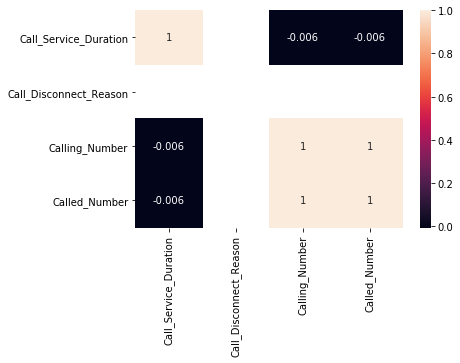

In [7]:
from pandas.plotting import scatter_matrix
stopNumPd = dataPd._get_numeric_data()
stopNumPd.columns 
stopNumPd.head

import seaborn as sns

# calculate the correlation matrix
corr = stopNumPd.corr()
# plot the heatmap

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)
plt.show()

##  Correlation Matrix

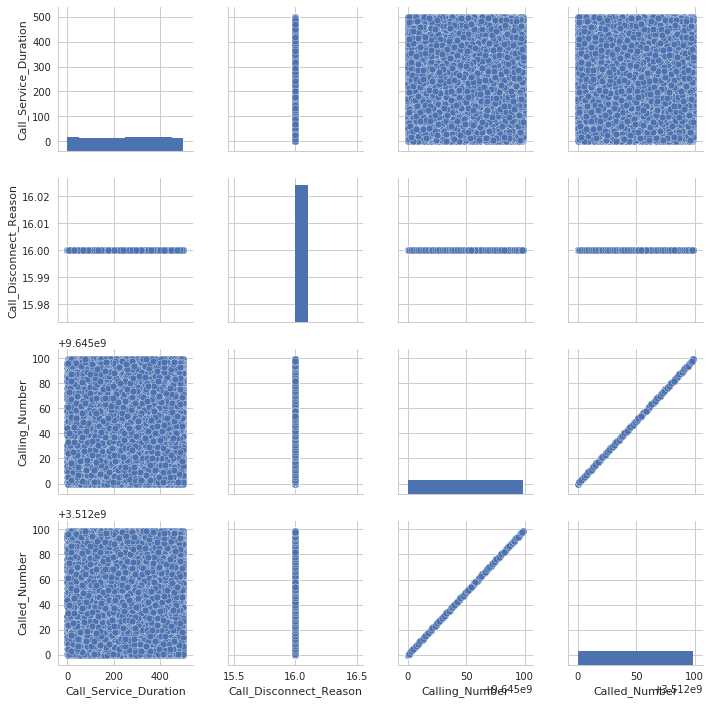

In [8]:
import seaborn as sns
sns.set(style='whitegrid',context='notebook')
sns.pairplot(dataPd[['Accounting_ID','Start_Time_MM_DD_YYYY','Start_Time_HH_MM_SS_s','Call_Service_Duration','Call_Disconnect_Reason','Calling_Number','Called_Number']])

- _The CDR dataset used posseses records with NORMAL CALL CLEARING(16), we are mocking the dataset with a random seed of > 0.5 % of records to represent as NOT NORMAL CALL CLEARING and hence injects 17._

In [9]:
#Mock Data
addDF = newDataDF
unionDF = addDF.union(newDataDF)
df = unionDF.drop('Call_Disconnect_Reason')

from pyspark.sql.functions import rand,when
df1 = df.withColumn('Call_Disconnect_Reason', when(rand(seed=1234) > 0.5, 16).otherwise(17))
df1.count()

44826

In [10]:
from pyspark.sql.functions import rand

trainingFraction = 0.70; testingFraction = (1-trainingFraction);
seed = 1234;

trainData, testData = df1.randomSplit([trainingFraction, testingFraction], seed=seed);

# # CACHE TRAIN AND TEST DATA
trainData.cache()
testData.cache()
trainData.count(),testData.count()

(31385, 13441)

In [11]:
from pyspark.ml.feature import StringIndexer
columns_list = list(set(newDataDF.columns)-set(['Call_Disconnect_Reason']) ) 
indexers = []
for column in columns_list:
    indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
    indexer.setHandleInvalid("skip")
    indexers.append(indexer)


In [12]:
from pyspark.ml.feature import StringIndexer
# Convert target into numerical categories
labelIndexer = StringIndexer(inputCol="Call_Disconnect_Reason", outputCol="label")
labelIndexer.setHandleInvalid("skip")

StringIndexer_446c9c6b4a0a5026447b

In [13]:
from pyspark.ml.feature import VectorAssembler
from array import array

inputcolsIndexer = []
for col in columns_list:
    inputcolsIndexer.append(col+"_index")
print(inputcolsIndexer)

vecAssembler = VectorAssembler(inputCols=inputcolsIndexer, outputCol="features")


['Start_Time_HH_MM_SS_s_index', 'Call_Service_Duration_index', 'Called_Number_index', 'Start_Time_MM_DD_YYYY_index', 'Accounting_ID_index', 'Calling_Number_index']


```
Random Forest Classifier: Random forests are a popular family of classification and regression methods. Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. The spark.ml implementation supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features.

```

In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxDepth=8, maxBins=2400000, numTrees=128,impurity="gini")


## Feature Importances


__ChiSqSelector__ implements Chi-Squared feature selection. It operates on labeled data with categorical features. ChiSqSelector uses the Chi-Squared test of independence to decide which features to choose. It supports five selection methods: numTopFeatures, percentile, fpr, fdr, fwe:

- _numTopFeatures chooses a fixed number of top features according to a chi-squared test. This is akin to yielding the features with the most predictive power._
    


In [15]:
from pyspark.ml.feature import ChiSqSelector
chisqSelector = ChiSqSelector(numTopFeatures=6, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="label")

In [16]:
from pyspark.ml import Pipeline
stages = []
stages += indexers 
stages += [labelIndexer]
stages += [vecAssembler]
stages += [rf]
stages += [chisqSelector]

pipeline = Pipeline(stages=stages)

In [17]:
train_sdata = trainData.sample(False,0.1)
test_sdata = testData.sample(False,0.1)
train_sdata.count(),test_sdata.count()

(3111, 1285)

In [18]:
%time
model = pipeline.fit(train_sdata)
predictions = model.transform(test_sdata)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


# Confusion Matrix


In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

outdataframe = predictions.select("label","prediction")
pandadf = outdataframe.toPandas()
npmat = pandadf.as_matrix()
labels = npmat[:,0]
predicted_label = npmat[:,1]

cnf_matrix = confusion_matrix(labels, predicted_label)


In [20]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('copper')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Call Disconnect Reason')
    plt.xlabel('Predicted \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

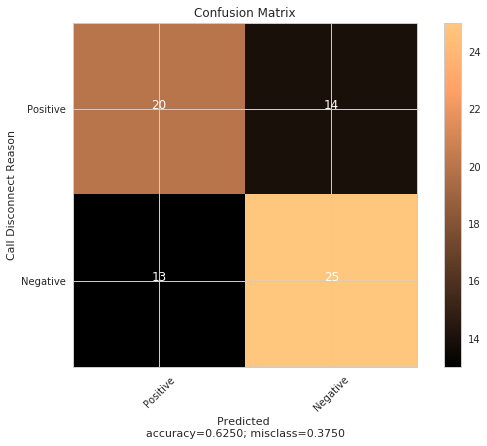

In [21]:
plot_confusion_matrix(cnf_matrix,
                      normalize    = False,
                      target_names = ['Positive', 'Negative'],
                      title        = "Confusion Matrix")

# Evaluate

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.375


In [23]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda lp: (float(lp.prediction), lp.label))
# Instantiate metrics object
metricsM = MulticlassMetrics(predictionAndLabels)
# Overall statistics
precision = metricsM.precision()
recall = metricsM.recall()
f1Score = metricsM.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)


Summary Stats
Precision = 0.625
Recall = 0.625
F1 Score = 0.625


In [24]:
# Statistics by class
labels = predictions.rdd.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metricsM.precision(label)))
    print("Class %s recall = %s" % (label, metricsM.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metricsM.fMeasure(label, beta=1.0)))
    print("Class %s TP = %s" % (label, metricsM.truePositiveRate(label)))
    print("Class %s FP = %s" % (label, metricsM.falsePositiveRate(label)))

  
## Weighted stats
print("Class %s WTP = %s" % (label, metricsM.weightedTruePositiveRate))
print("Class %s WFP = %s" % (label, metricsM.weightedFalsePositiveRate))

print("Weighted recall = %s" % metricsM.weightedRecall)
print("Weighted precision = %s" % metricsM.weightedPrecision)
print("Weighted F(1) Score = %s" % metricsM.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metricsM.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metricsM.weightedFalsePositiveRate)

Class 0.0 precision = 0.6060606060606061
Class 0.0 recall = 0.5882352941176471
Class 0.0 F1 Measure = 0.5970149253731343
Class 0.0 TP = 0.5882352941176471
Class 0.0 FP = 0.34210526315789475
Class 1.0 precision = 0.6410256410256411
Class 1.0 recall = 0.6578947368421053
Class 1.0 F1 Measure = 0.6493506493506495
Class 1.0 TP = 0.6578947368421053
Class 1.0 FP = 0.4117647058823529
Class 1.0 WTP = 0.625
Class 1.0 WFP = 0.3788699690402477
Weighted recall = 0.625
Weighted precision = 0.6245143745143745
Weighted F(1) Score = 0.6246365574723785
Weighted F(0.5) Score = 0.6245342193516333
Weighted false positive rate = 0.3788699690402477


# AUC

In [25]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# Instantiate metrics object

results = predictions.select(['probability', 'label'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
print(results_list)
scoreAndLabels = spark.sparkContext.parallelize(results_list)


metrics = BinaryClassificationMetrics(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)


[(0.633300856681553, 0.0), (0.002530747832802999, 1.0), (0.009952834828875502, 0.0), (0.008724721938155024, 0.0), (0.0009897431824456993, 0.0), (0.006622611224542218, 0.0), (0.009458155741816207, 0.0), (0.001626392488176709, 1.0), (0.0014874596506423902, 1.0), (0.0014641637427679044, 0.0), (0.0021489209838883357, 0.0), (0.0032740238860963743, 0.0), (0.005820789413332423, 0.0), (0.6239075975785051, 1.0), (0.7038022944566017, 1.0), (0.6371033355465207, 1.0), (0.6489474744252897, 1.0), (0.5770809114899815, 0.0), (0.006737534727915526, 1.0), (0.6912896588061062, 1.0), (0.018546327424751704, 0.0), (0.6885728165051447, 1.0), (0.006698005743333521, 1.0), (0.6899651322782697, 0.0), (0.725939971107056, 0.0), (0.0015693552499344017, 1.0), (0.010166161549943636, 0.0), (0.007444049559074803, 0.0), (0.04435938160274833, 0.0), (0.0040559601007211215, 0.0), (0.6863589836021269, 1.0), (0.681237097262059, 0.0), (0.0015067600401474273, 0.0), (0.6096383373362803, 1.0), (0.0014311079344373713, 0.0), (0.62

In [26]:
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)


Area under PR = 0.5475491895992292
Area under ROC = 0.5619195046439629


# Plot Receiver Operating Characteristic (ROC)

$$  FPR(T)=∫^∞_TP_0(T)dT \\
    TPR(T)=∫^∞_TP_1(T)dT $$






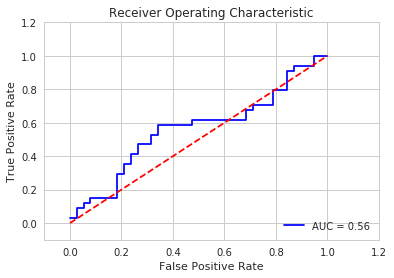

In [27]:
from pyspark.sql.functions import udf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

'''
To plot the ROC curve, we need the probability scores as predicted
by our model. However our model outputs a probability vector for each
record where it separately provides the probability for class 0 and also
for class 1. We first write a user-defined function to extract the 
probability for the positive '1' class from the probability vector.
'''
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

labels = y_test
probs = y_score


'''
We compute the false positive rate and true positive rate at various thresholds
of the probability score and use that to recompute the auc and finally to 
plot the ROC curve.
'''
false_positive_rate, true_positive_rate, thresholds = roc_curve(labels, probs)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


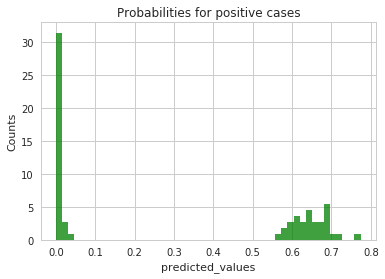

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


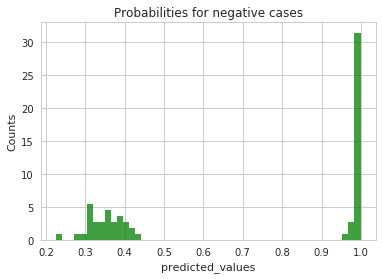

In [28]:
all_probs = predictions.select("probability").collect()

pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]
 
from matplotlib import pyplot as plt
%matplotlib inline
 
# pos
plt.hist(pos_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for positive cases')
plt.grid(True)
plt.show()
 
# neg
plt.hist(neg_probs, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for negative cases')
plt.grid(True)
plt.show()

# Plot Precision Recall


Average precision-recall score: 0.56


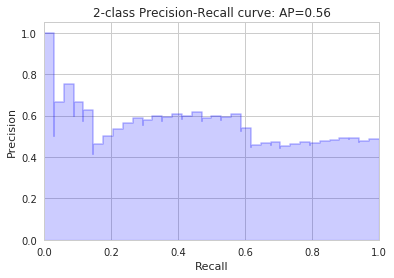

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(labels, probs)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(labels, probs)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
         average_precision))
plt.show()
